# Plot downsampled Ancients
Take the high-coverage Ancients, and plot results from their downampled Versions
1. Ancient SA: Are prepared in ./PrepareData/prepare_SA_readcount.ipynb and then run via ./ParallelRuns/parallel_AS_hdf5_callroh.ipynb

Here: For each Individual: Load RC and PH Inference, as well as Reich Eigenstrat PH inference. Then plot in one plot (if not loaded and not given to plotting function, not plotted)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os  # For Saving to Folder
import pandas as pd
from matplotlib import gridspec

##############################
import socket
import os as os
import sys as sys
import multiprocessing as mp

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./PackagesSupport/")
from pp_individual_roh_csvs import create_combined_ROH_df

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


## Prepare Data

### Ancient South Americans: Take example IPK12

### Load downsampled Inference

In [2]:
def prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour/", iid = "Loschbour",
                          suffix = "_roh_full.csv", down_sampling_covs=np.geomspace(0.01, 1.0, 10), cms = [4, 8, 12],
                            gap = 0.5, tot_cov=19.5486, prefix=""):
    """Prepare Dataframe of results -> Combine Individual results into one dataframe"""
    ###['IPY10', 'IPK12', 'MA577', '894', '895']
    #down_sampling_covs = np.geomspace(0.04, 1.0, 10)[:]  # Modify depending on how much Coverage has been loaded. FOR IPK12
    samples = np.array([prefix + f"{c:.4f}" for c in down_sampling_covs])   # Numpy Array for better slicing
    paths = [os.path.join(base_path, s[:10] + suffix) for s in samples]
    df_t = create_combined_ROH_df(paths, samples, pops=samples, min_cm=cms, snp_cm=50, gap=gap, output=False)
    df_t["mean_cov"] = down_sampling_covs * tot_cov   #* 10.439 for IPK12
    return df_t

## Create the Figure with loaded Data

In [44]:
#def plot_downsample_fig(df1):
def plot_downsample_ind(df_rc, df_ph=[], df_ph_reich=[], cms=[4,8,12], fs=10, fs_leg=10, figsize=(7,5),
                        title="IKP12, Patagonia, 1000y BP", xlim=[0, 2], ylim=[0, 550], savepath=""):
    """Plot downsampled Individual.
    df_ph: If given, plot pseudohaploid data"""
    mss = ["bo-", "bo--", "bo-."]
    plt.figure(figsize=figsize)
    ax=plt.gca()

    for i, cm in enumerate(cms):
        ### Plot the RC Line for cm
        #df_plot = df_ipk12[df_ipk12[">cm"]==cm]
        plt.plot(df_rc["mean_cov"], df_rc[f"sum_roh>{cm}"], mss[i], label=f">{cm}cm (Readcounts)", lw=1.5, ms=6, zorder=1, color="b")

        ### Plot PH Line for cm
        if len(df_ph)>0:
            plt.plot(df_ph["mean_cov"], df_ph[f"sum_roh>{cm}"], mss[i], label=f">{cm}cm (Pseudohaploid)", lw=1.5, ms=6, zorder=0, color="r")      
    
    if len(df_ph_reich)>0:
        y=[df_ph_reich[f"sum_roh>{cm}"].values[0] for cm in cms]
        plt.scatter(np.ones(len(cms)), y, c="r", s=80, ec="k", label="PseudoHaploid (Eigenstrat)", zorder=1)

    plt.legend(loc="upper right", fontsize=fs_leg)
    plt.ylim(ylim)

    plt.ylabel("Sum ROH >x cM [cM]", fontsize=fs)
    plt.xlabel("Mean Depth", fontsize=fs)
    plt.title(title, fontsize=fs)
    #plt.xscale("log")
    plt.xlim(xlim)
    ax.axvline(0.5, c="r")
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved Figure to: {savepath}")
    plt.show()

### Do IPKG12, South America

In [134]:
### Load Readcount Data
df_rc = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_IPK12/", iid = "IPK12",
                          suffix = "_roh_full.csv", down_sampling_covs = np.geomspace(0.04, 1.0, 10), cms = [4, 8, 12],
                            gap = 0.5, tot_cov=10.438989, prefix="IPK12")

In [131]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/IPK12.SG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["IPK12,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, gap=0.2, output=False)

In [135]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_IPK12/", iid = "IPK12",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 0.8, 6), cms = [4, 8, 12],
                       gap = 0.5, tot_cov=1.0, prefix="IPK12")  # Keep in mind the overall folder -> it's not PH bc old run diff

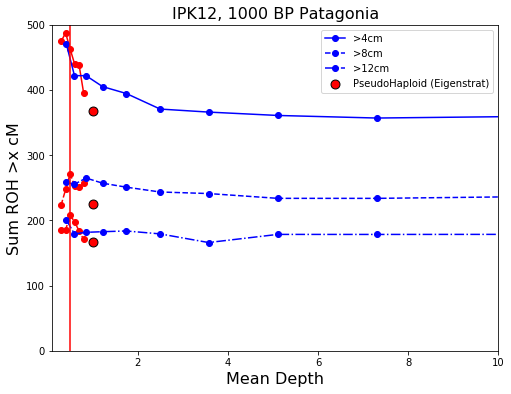

In [136]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="IPK12, 1000 BP Patagonia", ylim=[0,500], xlim=[0.1,10])

### Do Loschbour, WHG

In [68]:
### Downsampled Readcount
df_rc = prep_rc_res_df(tot_cov=19.5486)

In [75]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/Loschbour_snpAD.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["IPK12,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, gap=0.5, output=False)

In [95]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_ph/", iid = "Loschbour",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 0.8, 6), cms = [4, 8, 12],
                       gap = 0.5, tot_cov=1.0)

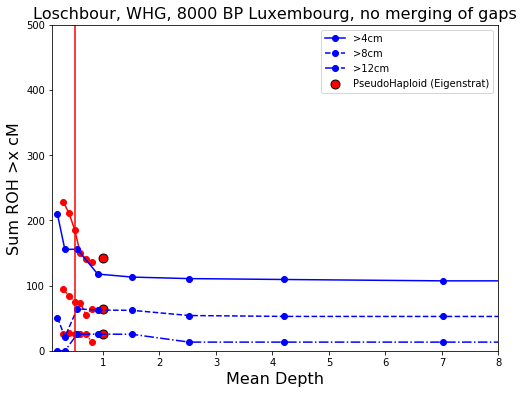

In [96]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="Loschbour, WHG, 8000 BP Luxembourg, no merging of gaps", ylim=[0,500], xlim=[0.1,8])

### Loschbour with 7 SNP cutoff on each side

In [61]:
### Downsampled Readcount
df_rc = prep_rc_res_df(tot_cov=19.5486)

### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/Loschbour_snpAD.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["IPK12,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, gap=0.5, output=False)

### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_ph/", iid = "Loschbour",
                       suffix = "_roh_fullE7.csv", down_sampling_covs=np.linspace(0.3, 0.8, 6), cms = [4, 8, 12],
                       gap = 0.0, tot_cov=1.0)

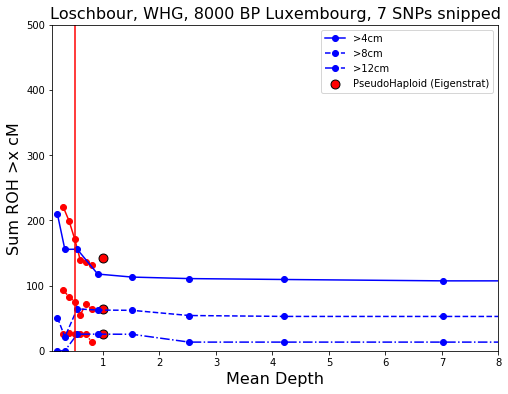

In [62]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="Loschbour, WHG, 8000 BP Luxembourg, 7 SNPs snipped", ylim=[0,500], xlim=[0.1,8])

### Compare snp'ed and non snp'ed

In [63]:
df_ph1 = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Loschbour_ph/", iid = "Loschbour",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 0.8, 6), cms = [4, 8, 12],
                       gap = 0.5, tot_cov=1.0)

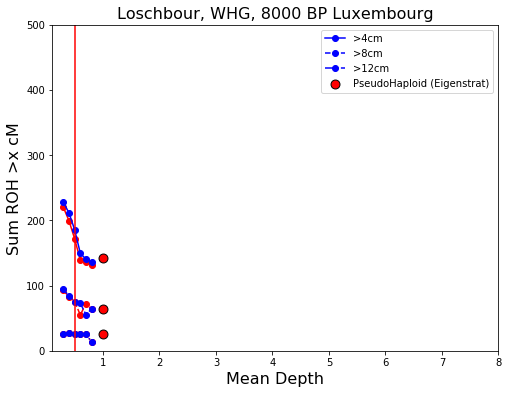

In [64]:
plot_downsample_ind(df_ph1, df_ph=df_ph, df_ph_reich=df_ph_reich, 
                    title="Loschbour, WHG, 8000 BP Luxembourg", ylim=[0,500], xlim=[0.1,8])

### Do Stuttgart EEF

In [24]:
### Load Readcount Data
df_rc = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Stuttgart/", iid = "Stuttgart",
                          suffix = "_roh_full.csv", down_sampling_covs=np.geomspace(0.01, 1.0, 10)[:], cms = [4, 8, 12],
                            gap = 0.5, tot_cov=18.2127)

In [25]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/Stuttgart_published.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["Stuttgart_published,"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, gap=0.5, output=False)

In [26]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Stuttgart_ph//", iid = "Stuttgart",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 1.0, 8), cms = [4, 8, 12],
                       gap = 0.5, tot_cov=1.0)

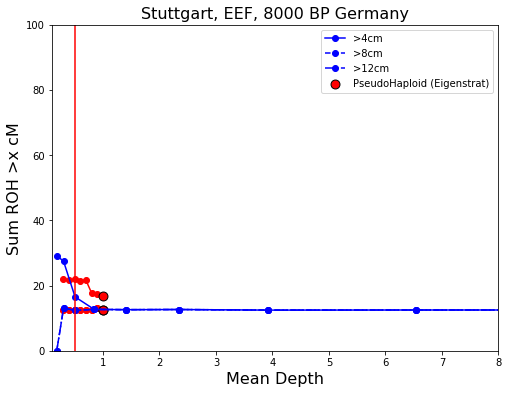

In [27]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=df_ph_reich, title="Stuttgart, EEF, 8000 BP Germany", ylim=[0,100], xlim=[0.1,8])
#df_ph=df_ph, df_ph_reich=df_ph_reich

### Ust Ishim (45k years old!)

In [6]:
### Load Readcount Data
df_rc = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim/", iid = "Ust_Ishim",
                          suffix = "_roh_fullE7.csv", down_sampling_covs=np.geomspace(0.005, 1.0, 10)[:], cms = [4, 8, 12],
                            gap = 0.5, tot_cov=40.0)

In [14]:
### Reich Eigenstrat PH
paths = ["./Empirical/Eigenstrat/Reichall/UstIshim_snpAD.DG_roh_full.csv",]
cms = [4, 8, 12]
iids=np.array(["UstIshim_snpAD.DG"])
df_ph_reich = create_combined_ROH_df(paths, iids, iids, min_cm=cms, snp_cm=50, gap=0.5, output=False)

In [26]:
### Downsampled PH
df_ph = prep_rc_res_df(base_path = "./Empirical/1240k/SA_Readcounts/Downsample_Ust_Ishim_ph/", iid = "Ust_Ishim",
                       suffix = "_roh_full.csv", down_sampling_covs=np.linspace(0.3, 1.0, 8), cms = [4, 8, 12],
                       gap = 0.5, tot_cov=1.0)

Saved Figure to: ./figures/manuscript/supplement/downsampling_sa/ust_ishim.pdf


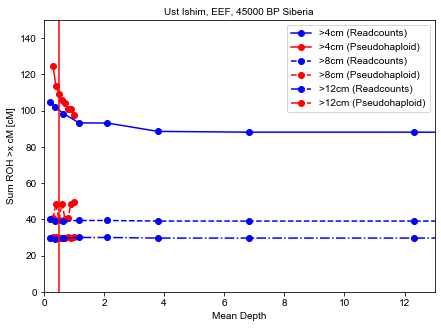

In [45]:
plot_downsample_ind(df_rc, df_ph=df_ph, df_ph_reich=[], title="Ust Ishim, EEF, 45000 BP Siberia", 
                    ylim=[0,150], xlim=[0,13], savepath="./figures/manuscript/supplement/downsampling_sa/ust_ishim.pdf")

# Area 51

# Compare SA Readcount with PH

In [3]:
from pp_individual_roh_csvs import create_combined_ROH_df, give_iid_paths, pp_individual_roh

In [4]:
iids = np.array(["A460", "Andaman", "5832", "Lovelock4", "Sumidouro4","Sumidouro5", 
        "Sumidouro6", "Sumidouro7"]) #, "19651", "AHUR_2064", "Lovelock1", "Lovelock2", "Lovelock3", "Aconcagua"]

In [37]:
paths = give_iid_paths(iids, base_folder="./Empirical/1240k/SA_Readcounts/", suffix='_roh_full.csv')
df1 = create_combined_ROH_df(paths, iids, pops=iids, min_cm=[4, 8, 12], snp_cm=50, gap=0.5, output=False)

In [38]:
df_es = pd.read_csv("./Empirical/Eigenstrat/Reichall/combined_roh05.csv", sep="\t")
df_es["iid"] = df_es["iid"].str.split(".", expand=True)[0]

In [46]:
df_merge = pd.merge(df1, df_es, on="iid")
df_merge = df_merge[df_merge["mean_cov"]>10]

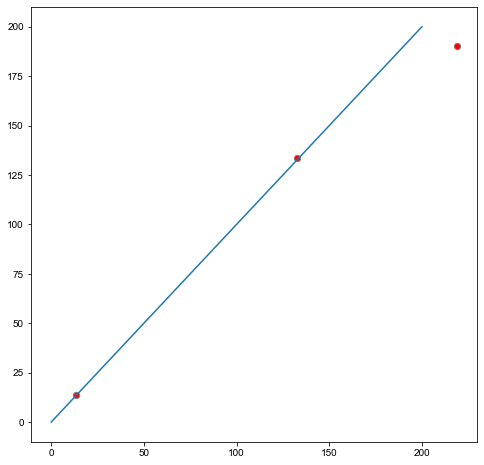

Correlation: 0.9938


In [49]:
cm1, cm2 = 4, 
x = df_merge[f"sum_roh>{cm1}_x"] #- df_merge[f"sum_roh>{cm2}_x"]
y = df_merge[f"sum_roh>{cm1}_y"] #- df_merge[f"sum_roh>{cm2}_y"]

plt.figure(figsize=(8,8))
plt.scatter(x, y, s=40, c="r", ec="gray")
plt.plot([0,200],[0,200])
plt.show()

print(f"Correlation: {np.corrcoef(x,y)[0,1]:.4f}")

In [42]:
np.mean(y-x)

40.38546733333332

In [43]:
np.mean(x)

82.50735600000002

In [44]:
np.mean(y)

122.89282333333334